Note: this notebook is adapted from the materials of the Geometric Probabilistic Models tutorial at [UAI 2024](https://www.auai.org/uai2024/tutorials) and the eponymous mini-course at [ProbAI 2025](https://nordic.probabilistic.ai/).

# Imports

In [1]:
%%capture
# Uncomment the line below if `pems-regression` is not installed in your environment.
# !pip install git+https://github.com/vabor112/pems-regression.git

In [2]:
# Basic Imports
import random
import numpy as np
import torch
import importlib.resources
import pickle
import networkx as nx
from functools import partial

import warnings
from tqdm import TqdmWarning

warnings.filterwarnings("ignore", category=TqdmWarning)

# Graph CNNs
from torch_geometric.data import Data

# GeometricKernels
import geometric_kernels
import geometric_kernels.torch
from geometric_kernels.spaces import Graph
from geometric_kernels.kernels import MaternGeometricKernel
from geometric_kernels.frontends.gpytorch import GPyTorchGeometricKernel

# Models
from pems_regression.models.bgcn import (  # Bayesian Graph CNN
    BayesianGCNModel,
    get_bnn_predictions_stds_and_test_cov,
)
from pems_regression.models.gcn import (  # Deterministc Graph CNN
    GCNModel,
    get_gcnn_predictions,
)
from pems_regression.models.gcn import (  # Graph CNN ensemble
    get_ensemble_predictions_stds_and_test_cov,
)
from pems_regression.models.gp import (  # Gaussian Process
    ExactGPModel,
    InverseCosineKernel,
    RandomWalkKernel,
    get_gp_predictions_stds_and_test_cov,
)

# Metrics
from pems_regression.metrics import (
    rmse as orig_rmse,
    full_cov_nll as orig_full_cov_nll,
    diag_cov_nll as orig_diag_cov_nll,
    print_metrics as orig_print_metrics,
)

# Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pems_regression.plotting.pems import (
    plot_PEMS,
    plot_prediction as orig_plot_prediction,
    plot_uncertainty as orig_plot_uncertainty,
)

# Utils
from pems_regression.utils import dcn

INFO (geometric_kernels): Numpy backend is enabled. To enable other backends, don't forget to `import geometric_kernels.*backend name*`.
INFO (geometric_kernels): We may be suppressing some logging of external libraries. To override the logging policy, call `logging.basicConfig`.
INFO (geometric_kernels): Torch backend enabled.
INFO (numexpr): NumExpr defaulting to 12 threads.


# Setup

In [3]:
if torch.cuda.is_available():
    torch.set_default_device("cuda")
    device = torch.device("cuda")
else:
    torch.set_default_device("cpu")
    device = torch.device("cpu")
torch.set_default_dtype(torch.float64)

# Settings and Seeds

In [4]:
%%capture

NUM_TRAIN = 250
NUM_MODELS_IN_ENSEMBLE = 10
MCMC_NUM_SAMPLES = 100
MCMC_NUM_CHAINS = 1

# The following may be different because different methods take very different
# time to train.
DET_NN_REPETITIONS = 5
ENS_REPETITIONS = 2
B_NN_REPETITIONS = 2
GP_REPETITIONS = 5

# Note: we will not be changing train/test split between experiments for visualization purposes
random.seed(1111)
np.random.seed(1111)
torch.manual_seed(1111)

# Whether or not to remove plot backgrounds
NO_BACKGROUND = False

# Data

## Prepare Data

The nasty details of the PEMS dataset preparation are hidden away in the preprocessing module in https://github.com/spbu-math-cs/Graph-Gaussian-Processes/tree/main/examples/utils.

In [5]:
with importlib.resources.files("pems_regression.resources").joinpath(
    "processed_pems_data.pkl"
).open("rb") as f:
    nx_graph, data = pickle.load(f)

# Splitting data into train and test
random_perm = np.random.permutation(np.arange(data[0].shape[0]))
train_vertex, test_vertex = random_perm[:NUM_TRAIN], random_perm[NUM_TRAIN:]
xs_train = torch.tensor(data[0][train_vertex], dtype=torch.int64)
ys_train = torch.tensor(data[1][train_vertex], dtype=torch.float64)

xs_test = torch.tensor(data[0][test_vertex], dtype=torch.int64)
ys_test = torch.tensor(data[1][test_vertex], dtype=torch.float64)

num_nodes = len(nx_graph)
xs = torch.arange(num_nodes)

# Note: since there is lots of _actually_ unknown y-s, the `ys` array will have
# lots of NaN-s.
ys = torch.full((num_nodes,), np.nan, dtype=torch.float64)
ys[xs_train.squeeze()] = ys_train.squeeze()
ys[xs_test.squeeze()] = ys_test.squeeze()
ys = ys[:, None]

Center and normalize the outputs

In [6]:
# Important to compute these _before_ centering/normalization
y_min = min(torch.min(ys_train), torch.min(ys_test))
y_max = max(torch.max(ys_train), torch.max(ys_test))

orig_mean, orig_std = torch.mean(ys_train), torch.std(ys_train)
print(f"orig_mean = {orig_mean} | orig_std = {orig_std}.")
ys_train = (ys_train - orig_mean) / orig_std
ys_test = (ys_test - orig_mean) / orig_std
ys = (ys - orig_mean) / orig_std

orig_mean = 51.06 | orig_std = 17.334115675887833.


Extract adjacency matrix from the loaded networkx graph and check that it passes sanity checks

In [7]:
adj_mat = torch.tensor(nx.to_numpy_array(nx_graph))

# Sanity checks
assert torch.allclose(adj_mat, adj_mat.T), "Adjacency matrix is not symmetric!"
assert torch.all(adj_mat >= 0.0), "Adjacency matrix contains negative elements!"
assert (
    torch.sum(adj_mat.diagonal() ** 2) == 0.0
), "Adjacency matrix has non-zeros on diagonal!"

Prepare data in the PyTorch Geometric format

In [8]:
masked_ys = torch.nan_to_num(ys)
masked_ys[xs_test.squeeze()] = 0.0

train_mask = torch.full((num_nodes,), False, dtype=torch.bool)
train_mask[xs_train.squeeze()] = True
test_mask = torch.full((num_nodes,), False, dtype=torch.bool)
test_mask[xs_test.squeeze()] = True

pyg_data = Data(
    x=masked_ys,
    edge_index=adj_mat.to_sparse().indices(),
    edge_weight=adj_mat.to_sparse().values(),
    y=ys,
    train_mask=train_mask,
    test_mask=test_mask,
)

## Metrics shorthands

In [9]:
rmse = partial(orig_rmse, observation=ys_test, original_std=orig_std)
full_cov_nll = partial(orig_full_cov_nll, observation=ys_test)
diag_cov_nll = partial(orig_diag_cov_nll, observation=ys_test)

print_metrics = partial(
    orig_print_metrics,
    xs_train=xs_train,
    ys_train=ys_train,
    xs_test=xs_test,
    ys_test=ys_test,
    original_std=orig_std,
)

## Metrics for Trivial Baselines

In [10]:
# The trivial baseline: returns orig_mean as prediction and orig_std as standard
# deviation (which turn into zero and one after normalization and centering).
trivial_mean = torch.zeros_like(ys_test)
trivial_std = torch.ones_like(ys_test)
trivial_cov = torch.eye(ys_test.shape[0])

trivial_rmse = rmse(trivial_mean)

# The following two are supposed to coincide, we only compute both for the sake
# of a sanity check. Also note, we do not uncenter/unnormalize data before
# computing nll. This is intentional: it only changes all the nll values by the
# _same_ constant, and the absolute value of nll has little meaning anyway.
trivial_diag_nll = diag_cov_nll(trivial_mean, trivial_std)
trivial_full_nll = full_cov_nll(trivial_mean, trivial_cov)

print(f"Test RMSE is {trivial_rmse:.2f}")
print(f"Test diag-NLL is {trivial_diag_nll:.2f}")
print(f"Test full-NLL is {trivial_full_nll:.2f}")

Test RMSE is 16.43
Test diag-NLL is 102.62
Test full-NLL is 102.62


## Plotting Shorthands

In [11]:
# vmin, vmax = y_min, y_max  # 9, 70.7
# vmin, vmax = 0, 80
vmin, vmax = 10, 70
alpha_global = 0.6
alpha_local = 0.95

In [12]:
plot_prediction = partial(
    orig_plot_prediction,
    nx_graph=nx_graph,
    xs=xs,
    orig_mean=orig_mean,
    orig_std=orig_std,
    vmin=vmin,
    vmax=vmax,
    xs_train=xs_train,
    alpha_global=alpha_global,
    alpha_local=alpha_local,
)

plot_uncertainty = partial(
    orig_plot_uncertainty,
    nx_graph=nx_graph,
    xs=xs,
    orig_std=orig_std,
    vmin=0,
    vmax=18,
    xs_train=xs_train,
    alpha_global=alpha_global,
    alpha_local=alpha_local,
)

## Visualize Data

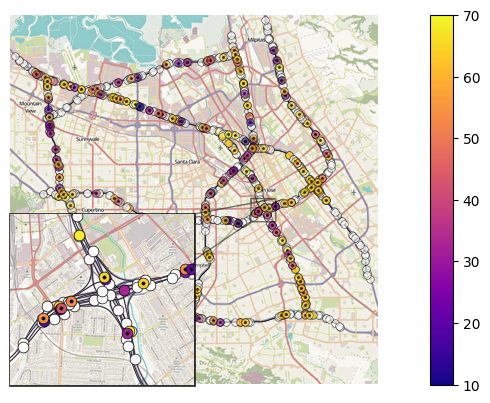

In [13]:
fig, ax = plt.subplots()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plot_PEMS(
    nx_graph,
    dcn(ys),
    dcn(xs),
    (dcn(orig_mean), dcn(orig_std)),
    ax=ax,
    fig=fig,
    cax=cax,
    vmin=vmin,
    vmax=vmax,
    bbox=(37.450, 37.210, -121.80, -122.10),
    nodes_to_label=dcn(xs_train),
    node_size=30,
    alpha=alpha_global,
    edge_linewidth=0.4,
    cmap_name="plasma",
)

inner_ax = ax.inset_axes((0, -0.02, 0.5, 0.5))


plot_PEMS(
    nx_graph,
    dcn(ys),
    dcn(xs),
    (dcn(orig_mean), dcn(orig_std)),
    ax=inner_ax,
    fig=fig,
    cax=None,
    vmin=vmin,
    vmax=vmax,
    bbox=(37.330741, 37.315718, -121.883005, -121.903327),
    nodes_to_label=dcn(xs_train),
    node_size=60,
    alpha=alpha_local,
    edge_linewidth=0.4,
    cmap_name="plasma",
)

inner_ax.patch.set_edgecolor((0, 0, 0, 0.8))
inner_ax.patch.set_linewidth(2)

ax.indicate_inset_zoom(inner_ax, edgecolor=(0, 0, 0, 0.8))

plt.show()

## Visualize Baselines

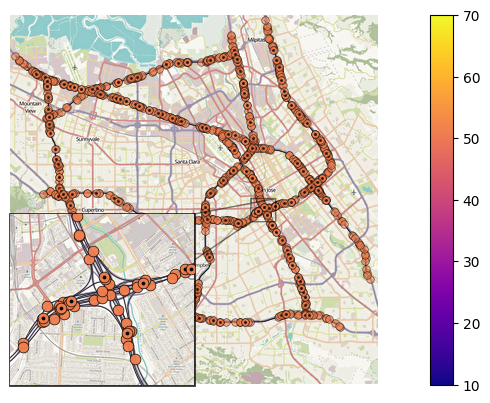

In [14]:
plot_prediction(torch.zeros_like(ys))

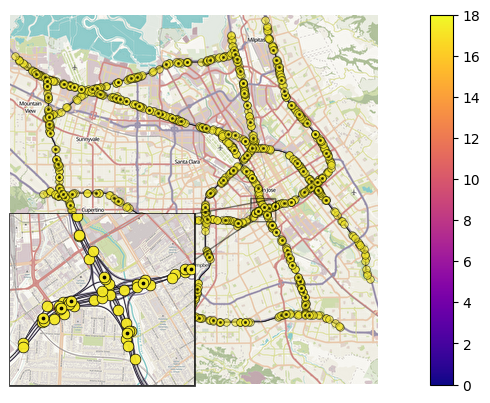

In [15]:
plot_uncertainty(torch.ones_like(ys))

Cleaning up

In [16]:
del vmin, vmax

# Fitting a Deterministic Graph Neural Network

## Shallow Network

### Train the Model

In [17]:
shallow_nn_results = []
for i in range(DET_NN_REPETITIONS):
    shallow_nn_pred = get_gcnn_predictions(100, 1, pyg_data=pyg_data)
    shallow_nn_results.append((shallow_nn_pred, None, None))

Epochs:    1 | Cur loss: 0.9987501268
Epochs:  101 | Cur loss: 0.2509162425
Epochs:  201 | Cur loss: 0.2328345132
Epochs:  301 | Cur loss: 0.2268480021
Epochs:  401 | Cur loss: 0.2211235996
Epochs:    1 | Cur loss: 0.9874023640
Epochs:  101 | Cur loss: 0.2662649264
Epochs:  201 | Cur loss: 0.2340450994
Epochs:  301 | Cur loss: 0.2252406857
Epochs:  401 | Cur loss: 0.2179228306
Epochs:    1 | Cur loss: 1.0502413606
Epochs:  101 | Cur loss: 0.2482819162
Epochs:  201 | Cur loss: 0.2342772713
Epochs:  301 | Cur loss: 0.2306339049
Epochs:  401 | Cur loss: 0.2255645974
Epochs:    1 | Cur loss: 0.9650965214
Epochs:  101 | Cur loss: 0.2603167074
Epochs:  201 | Cur loss: 0.2342414708
Epochs:  301 | Cur loss: 0.2267497484
Epochs:  401 | Cur loss: 0.2162944186
Epochs:    1 | Cur loss: 0.9164618257
Epochs:  101 | Cur loss: 0.2441089506
Epochs:  201 | Cur loss: 0.2340797057
Epochs:  301 | Cur loss: 0.2312246839
Epochs:  401 | Cur loss: 0.2292192049


### Metrics

In [18]:
shallow_nn_best_pred, _ = print_metrics(shallow_nn_results)

Test RMSE is 13.44 ± 0.07 (best: 13.35)
Train RMSE is 8.06 ± 0.12


### Visualize Results

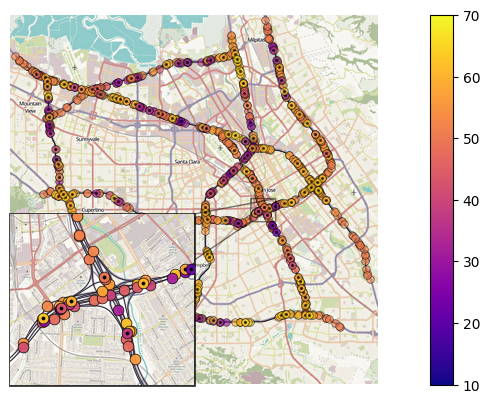

In [19]:
plot_prediction(shallow_nn_best_pred)

## Deep Network

### Train the Model

In [20]:
deep_nn_results = []
for i in range(DET_NN_REPETITIONS):
    deep_nn_pred = get_gcnn_predictions(100, 7, pyg_data=pyg_data)
    deep_nn_results.append((deep_nn_pred, None, None))

Epochs:    1 | Cur loss: 0.9998835402
Epochs:  101 | Cur loss: 0.2799812710
Epochs:  201 | Cur loss: 0.2547430620
Epochs:  301 | Cur loss: 0.2480766092
Epochs:  401 | Cur loss: 0.2445259638
Epochs:    1 | Cur loss: 0.9960544231
Epochs:  101 | Cur loss: 0.2911099275
Epochs:  201 | Cur loss: 0.2622489285
Epochs:  301 | Cur loss: 0.2522704159
Epochs:  401 | Cur loss: 0.2477433146
Epochs:    1 | Cur loss: 0.9938796434
Epochs:  101 | Cur loss: 0.3002411147
Epochs:  201 | Cur loss: 0.2672927858
Epochs:  301 | Cur loss: 0.2553017114
Epochs:  401 | Cur loss: 0.2479315787
Epochs:    1 | Cur loss: 0.9979376103
Epochs:  101 | Cur loss: 0.3114212018
Epochs:  201 | Cur loss: 0.2679491416
Epochs:  301 | Cur loss: 0.2512320774
Epochs:  401 | Cur loss: 0.2466730721
Epochs:    1 | Cur loss: 1.0002984431
Epochs:  101 | Cur loss: 0.3143985265
Epochs:  201 | Cur loss: 0.2738213298
Epochs:  301 | Cur loss: 0.2574075103
Epochs:  401 | Cur loss: 0.2502500332


### Metrics

In [21]:
deep_nn_best_pred, _ = print_metrics(deep_nn_results)

Test RMSE is 12.59 ± 0.07 (best: 12.47)
Train RMSE is 8.56 ± 0.03


### Visualize Results

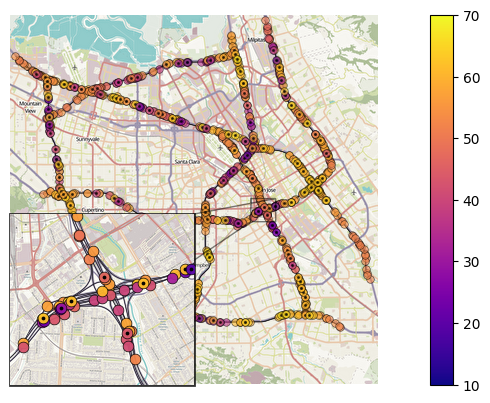

In [22]:
plot_prediction(deep_nn_best_pred)

# Fitting an Ensemble of Graph Neural Networks

## Train the Model

In [23]:
ens_results = []
for i in range(ENS_REPETITIONS):
    ens_results.append(
        get_ensemble_predictions_stds_and_test_cov(
            NUM_MODELS_IN_ENSEMBLE,
            xs_test=xs_test,
            ys=ys,
            pyg_data=pyg_data,
            layer_width=100,
            num_intermediate_layers=7,
        )
    )

Epochs:  500 | Cur loss: 0.2483959331
Epochs:  500 | Cur loss: 0.2423601732
Epochs:  500 | Cur loss: 0.2317204622
Epochs:  500 | Cur loss: 0.2484095801
Epochs:  500 | Cur loss: 0.2401590600
Epochs:  500 | Cur loss: 0.2414742470
Epochs:  500 | Cur loss: 0.2356766835
Epochs:  500 | Cur loss: 0.2389341389
Epochs:  500 | Cur loss: 0.2519804051
Epochs:  500 | Cur loss: 0.2495210583
Epochs:  500 | Cur loss: 0.2482886382
Epochs:  500 | Cur loss: 0.2495007217
Epochs:  500 | Cur loss: 0.2419304644
Epochs:  500 | Cur loss: 0.2410943765
Epochs:  500 | Cur loss: 0.2357284212
Epochs:  500 | Cur loss: 0.2432801229
Epochs:  500 | Cur loss: 0.2429657704
Epochs:  500 | Cur loss: 0.2539384861
Epochs:  500 | Cur loss: 0.2423558402
Epochs:  500 | Cur loss: 0.2418109836


## Metrics

In [24]:
ens_best_pred, ens_best_std = print_metrics(ens_results)

Test RMSE is 12.57 ± 0.01 (best: 12.56)
Train RMSE is 8.53 ± 0.01
Test diag-NLL is 25561.02 ± 1023.28 (best: 24537.74)
Test full-NLL is 152532.46 ± 1319.14 (best: 151213.32)


## Visualize Results

Visualize prediction

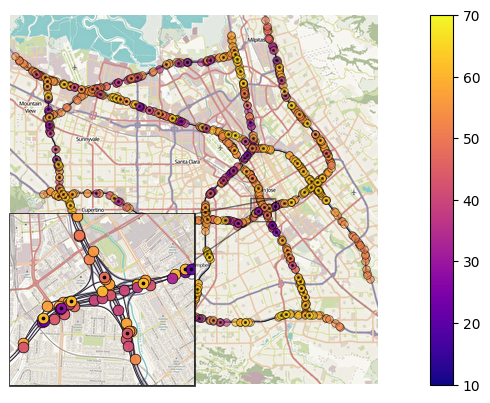

In [25]:
plot_prediction(ens_best_pred)

Visualize uncertainty

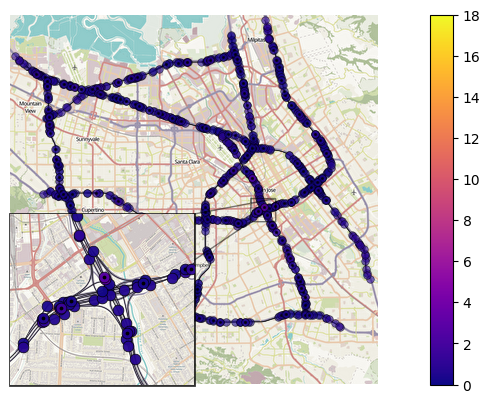

In [26]:
plot_uncertainty(ens_best_std)

# Fitting a Bayesian Graph Neural Network

## Wide Network

### Train the Model

In [27]:
wide_bnn_results = []
for i in range(B_NN_REPETITIONS):
    wide_bnn_results.append(
        get_bnn_predictions_stds_and_test_cov(
            100,
            7,
            pyg_data=pyg_data,
            xs_test=xs_test,
            ys=ys,
            train_mask=train_mask,
            num_samples=MCMC_NUM_SAMPLES,
            num_chains=MCMC_NUM_CHAINS,
        )
    )

Sample: 100%|██████████████████████████████████████████| 200/200 [00:13, 15.01it/s, step size=7.37e-07, acc. prob=0.170]                                                                   
/Users/vabor112/anaconda3/envs/pems_node_regression_1/lib/python3.11/site-packages/pyro/infer/mcmc/util.py:681: FutureWarning: The `mcmc.predictive` function is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  warnings.warn(
Sample: 100%|██████████████████████████████████████████| 200/200 [00:16, 12.01it/s, step size=4.87e-06, acc. prob=0.377]                                                                   


### Metrics

In [28]:
wide_bnn_best_pred, wide_bnn_best_std = print_metrics(wide_bnn_results)

Test RMSE is 4414856.77 ± 974963.12 (best: 3439893.64)
Train RMSE is 6517602.86 ± 2181587.09
Test diag-NLL is 689554.54 ± 414365.64 (best: 275188.89)
Test full-NLL is 19535417441.22 ± 18231646773.11 (best: 1303770668.11)


### Visualize Results

visualize prediction

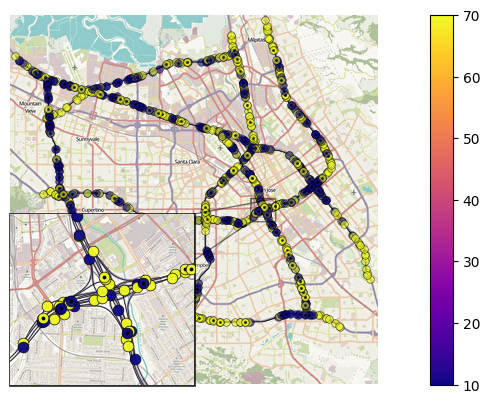

In [29]:
plot_prediction(wide_bnn_best_pred)

visualize uncertainty

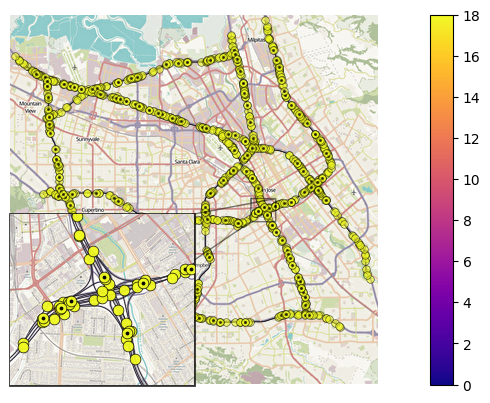

In [30]:
plot_uncertainty(wide_bnn_best_std)

## Narrow Network

### Train the Model

In [31]:
narrow_bnn_results = []
for i in range(B_NN_REPETITIONS):
    narrow_bnn_results.append(
        get_bnn_predictions_stds_and_test_cov(
            10,
            7,
            pyg_data=pyg_data,
            xs_test=xs_test,
            ys=ys,
            train_mask=train_mask,
            num_samples=MCMC_NUM_SAMPLES,
            num_chains=MCMC_NUM_CHAINS,
        )
    )

Sample: 100%|██████████████████████████████████████████| 200/200 [19:02,  5.71s/it, step size=2.85e-04, acc. prob=0.896]                                                                   
/Users/vabor112/anaconda3/envs/pems_node_regression_1/lib/python3.11/site-packages/pyro/infer/mcmc/util.py:681: FutureWarning: The `mcmc.predictive` function is deprecated and will be removed in a future release. Use the `pyro.infer.Predictive` class instead.
  warnings.warn(
Sample: 100%|██████████████████████████████████████████| 200/200 [19:27,  5.84s/it, step size=3.76e-03, acc. prob=0.758]                                                                   


### Metrics

In [32]:
narrow_bnn_best_pred, narrow_bnn_best_std = print_metrics(narrow_bnn_results)

Test RMSE is 13.92 ± 1.17 (best: 12.75)
Train RMSE is 10.57 ± 2.05
Test diag-NLL is 99.94 ± 0.08 (best: 99.86)
Test full-NLL is 220.79 ± 40.70 (best: 180.09)


### Visualize Results

visualize prediction

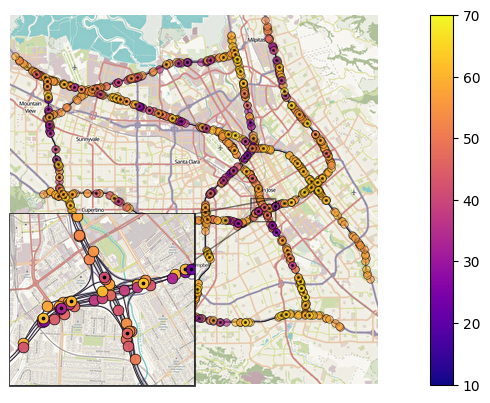

In [33]:
plot_prediction(narrow_bnn_best_pred)

visualize uncertainty

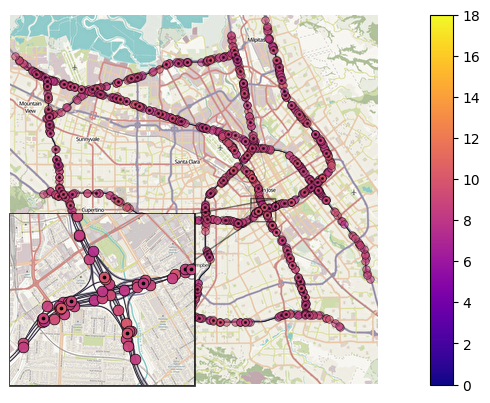

In [34]:
plot_uncertainty(narrow_bnn_best_std)

# Fitting a Gaussian Process

## Inverse Cosine Kernel

### Define and Train the Model

In [35]:
ic_kernel = GPyTorchGeometricKernel(
    InverseCosineKernel(
        Graph(
            adj_mat,
            normalize_laplacian=True,  # False would not work in this case (inv cos would produce negative eigenvalues)
        )
    ),
    nu=torch.tensor([1.0]),
    lengthscale=torch.tensor([1.0]),
    trainable_nu=False,
)

ic_gp_results = []
for i in range(GP_REPETITIONS):
    ic_gp_results.append(
        get_gp_predictions_stds_and_test_cov(
            ic_kernel,
            xs=xs,
            xs_train=xs_train,
            ys_train=ys_train,
            xs_test=xs_test,
        )
    )

Initial gp_model:
kernel.base_kernel.nu = [1.]
kernel.base_kernel.lengthscale = [[1.]]
kernel.outputscale = 1.0
likelihood.obs_noise = [0.01]

Iter 1/200 - Loss: 1.61730
Iter 20/200 - Loss: 1.50859
Iter 40/200 - Loss: 1.41935
Iter 60/200 - Loss: 1.41272
Iter 80/200 - Loss: 1.41258
Iter 100/200 - Loss: 1.41257
Iter 120/200 - Loss: 1.41256
Iter 140/200 - Loss: 1.41256
Iter 160/200 - Loss: 1.41256
Iter 180/200 - Loss: 1.41256
Iter 200/200 - Loss: 1.41256

Final model:
kernel.base_kernel.nu = [1.]
kernel.base_kernel.lengthscale = [[1.]]
kernel.outputscale = 0.3453632512759998
likelihood.obs_noise = [0.65425086]
Initial gp_model:
kernel.base_kernel.nu = [1.]
kernel.base_kernel.lengthscale = [[1.]]
kernel.outputscale = 1.0
likelihood.obs_noise = [0.01]

Iter 1/200 - Loss: 1.61730
Iter 20/200 - Loss: 1.50859
Iter 40/200 - Loss: 1.41935
Iter 60/200 - Loss: 1.41272
Iter 80/200 - Loss: 1.41258
Iter 100/200 - Loss: 1.41257
Iter 120/200 - Loss: 1.41256
Iter 140/200 - Loss: 1.41256
Iter 160/200 - L

### Metrics

In [36]:
ic_gp_best_pred, ic_gp_best_std = print_metrics(ic_gp_results)

Test RMSE is 16.45 ± 0.00 (best: 16.45)
Train RMSE is 11.45 ± 0.00
Test diag-NLL is 102.09 ± 0.00 (best: 102.09)
Test full-NLL is 101.82 ± 0.00 (best: 101.82)


### Visualize Results

visualize prediction

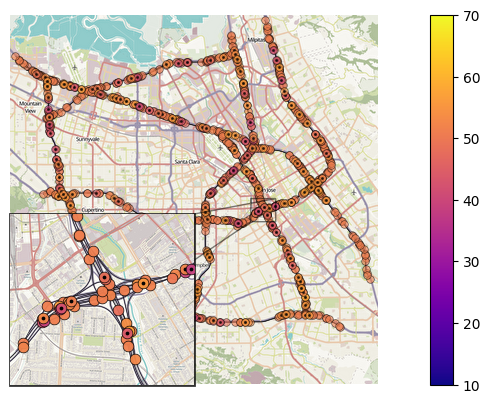

In [37]:
plot_prediction(ic_gp_best_pred)

visualize uncertainty

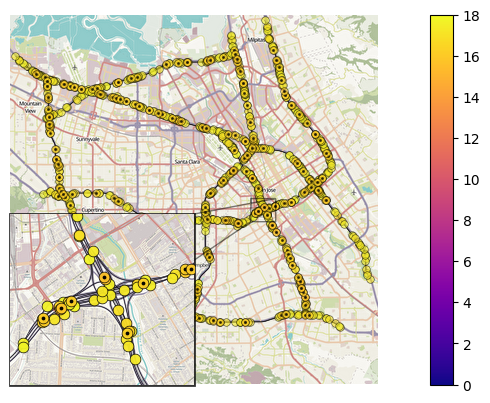

In [38]:
plot_uncertainty(ic_gp_best_std)

## Random Walk Kernel

### Define and Train the Model

In [39]:
rw_gp_results = []
for i in range(GP_REPETITIONS):
    rw_kernel = GPyTorchGeometricKernel(
        RandomWalkKernel(
            Graph(
                adj_mat,
                normalize_laplacian=True,  # False would not work in this case (random walk's Phi would produce negative eigenvalues)
            )
        ),
        nu=torch.tensor(
            torch.randint(2, 20, (1,), dtype=torch.float64)
        ),  # here, this is an important parameter
        lengthscale=torch.tensor(torch.rand(1, dtype=torch.float64) * 9 + 1.0),
        trainable_nu=False,  # setting this to True improves the kernel but goes beyond what is typically meant by the random-walk kernel
    )
    rw_gp_results.append(
        get_gp_predictions_stds_and_test_cov(
            rw_kernel,
            xs=xs,
            xs_train=xs_train,
            ys_train=ys_train,
            xs_test=xs_test,
        )
    )

/Users/vabor112/anaconda3/envs/pems_node_regression_1/lib/python3.11/site-packages/torch/utils/_device.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


Initial gp_model:
kernel.base_kernel.nu = [19.]
kernel.base_kernel.lengthscale = [[9.09645624]]
kernel.outputscale = 1.0
likelihood.obs_noise = [0.01]

Iter 1/200 - Loss: 1.52523
Iter 20/200 - Loss: 1.43051
Iter 40/200 - Loss: 1.38739
Iter 60/200 - Loss: 1.38724
Iter 80/200 - Loss: 1.38615
Iter 100/200 - Loss: 1.38571
Iter 120/200 - Loss: 1.38519
Iter 140/200 - Loss: 1.38457
Iter 160/200 - Loss: 1.38382
Iter 180/200 - Loss: 1.38292
Iter 200/200 - Loss: 1.38182

Final model:
kernel.base_kernel.nu = [19.]
kernel.base_kernel.lengthscale = [[9.18043992]]
kernel.outputscale = 0.5438252922241501
likelihood.obs_noise = [0.39907954]
Initial gp_model:
kernel.base_kernel.nu = [10.]
kernel.base_kernel.lengthscale = [[1.81817207]]
kernel.outputscale = 1.0
likelihood.obs_noise = [0.01]

Iter 1/200 - Loss: 2.55945
Iter 20/200 - Loss: 1.58426
Iter 40/200 - Loss: 1.47275
Iter 60/200 - Loss: 1.41943
Iter 80/200 - Loss: 1.39612
Iter 100/200 - Loss: 1.38742
Iter 120/200 - Loss: 1.38487
Iter 140/200 - Los

### Metrics

In [40]:
rw_gp_best_pred, rw_gp_best_std = print_metrics(rw_gp_results)

Test RMSE is 14.67 ± 0.47 (best: 14.05)
Train RMSE is 7.84 ± 0.37
Test diag-NLL is 95.94 ± 1.43 (best: 94.09)
Test full-NLL is 94.22 ± 1.65 (best: 92.09)


### Visualize Results

visualize prediction

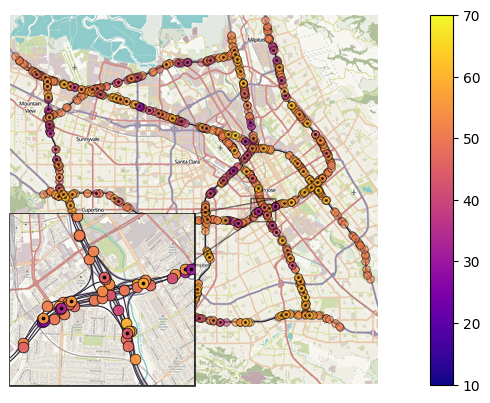

In [41]:
plot_prediction(rw_gp_best_pred)

visualize uncertainty

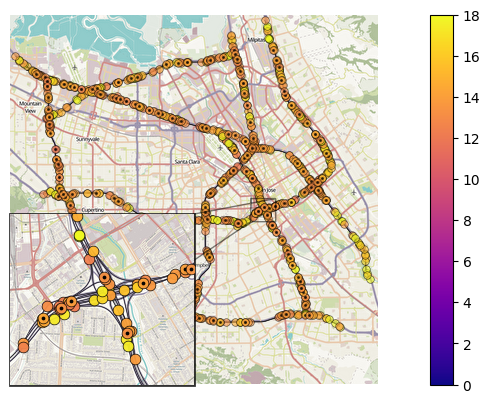

In [42]:
plot_uncertainty(rw_gp_best_std)

## Geometric Matérn Kernel

### Define and Train the Model

In [43]:
m_gp_results = []
for i in range(GP_REPETITIONS):
    m_kernel = GPyTorchGeometricKernel(
        MaternGeometricKernel(Graph(adj_mat, False)),
        nu=torch.rand(1, dtype=torch.float64) * 9 + 1.0,
        lengthscale=torch.rand(1, dtype=torch.float64) * 9 + 1.0,
        trainable_nu=False,
    )
    m_gp_results.append(
        get_gp_predictions_stds_and_test_cov(
            m_kernel,
            xs=xs,
            xs_train=xs_train,
            ys_train=ys_train,
            xs_test=xs_test,
        )
    )

Initial gp_model:
kernel.base_kernel.nu = [3.6149088]
kernel.base_kernel.lengthscale = [[5.93204279]]
kernel.outputscale = 1.0
likelihood.obs_noise = [0.01]

Iter 1/200 - Loss: 6.60601
Iter 20/200 - Loss: 1.94250
Iter 40/200 - Loss: 1.52668
Iter 60/200 - Loss: 1.41860
Iter 80/200 - Loss: 1.33144
Iter 100/200 - Loss: 1.26904
Iter 120/200 - Loss: 1.24426
Iter 140/200 - Loss: 1.23389
Iter 160/200 - Loss: 1.22744
Iter 180/200 - Loss: 1.22298
Iter 200/200 - Loss: 1.21951

Final model:
kernel.base_kernel.nu = [3.6149088]
kernel.base_kernel.lengthscale = [[4.95251534]]
kernel.outputscale = 0.5530662757382218
likelihood.obs_noise = [0.35083773]
Initial gp_model:
kernel.base_kernel.nu = [3.27801892]
kernel.base_kernel.lengthscale = [[3.64239244]]
kernel.outputscale = 1.0
likelihood.obs_noise = [0.01]

Iter 1/200 - Loss: 4.11946
Iter 20/200 - Loss: 1.72709
Iter 40/200 - Loss: 1.48506
Iter 60/200 - Loss: 1.36835
Iter 80/200 - Loss: 1.32120
Iter 100/200 - Loss: 1.28768
Iter 120/200 - Loss: 1.26527

### Metrics

In [44]:
m_gp_best_pred, m_gp_best_std = print_metrics(m_gp_results)

Test RMSE is 11.09 ± 0.09 (best: 10.99)
Train RMSE is 8.47 ± 0.31
Test diag-NLL is 73.87 ± 1.07 (best: 71.99)
Test full-NLL is 75.13 ± 0.54 (best: 74.29)


### Visualize Results

visualize prediction

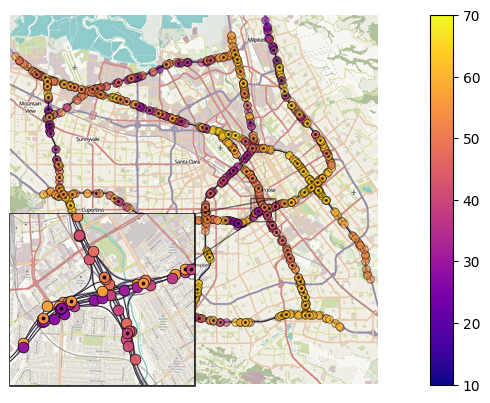

In [45]:
plot_prediction(m_gp_best_pred)

visualize uncertainty

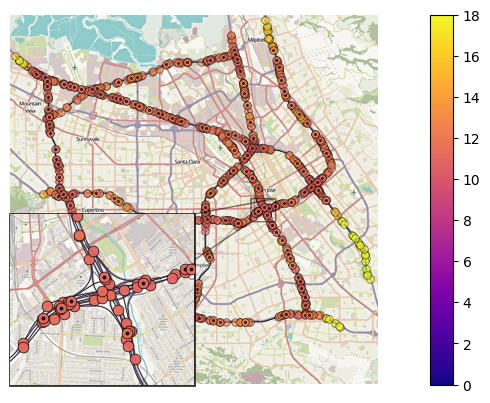

In [46]:
plot_uncertainty(m_gp_best_std)